<a href="https://colab.research.google.com/github/sandipanbasu/aiml-capstone/blob/master/mrc_Evaluations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Imports

In [4]:
import warnings
from tqdm import tqdm
from datetime import datetime
import tensorflow as tf
tf.debugging.set_log_device_placement(False)
import pickle
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import pprint
from tensorflow.keras.layers import Bidirectional,LSTM,Dense,Dropout,BatchNormalization,Flatten,Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from numpy import array
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score,accuracy_score,precision_score
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

model_path = "/content/drive/My Drive/AIML-MRC-Capstone/models/"
dataset_path = "/content/drive/My Drive/AIML-MRC-Capstone/datasets/"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Load Google Bucket as drive 

<font color=red>SKIP THIS SECTION</font>

In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = 'ai-ml-capstone'
!gcloud config set project {project_id}
!gsutil ls


KeyboardInterrupt: ignored

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

In [ ]:
!mkdir gbucket
!gcsfuse --implicit-dirs aiml-capstone gbucket 
# !umount gbucket

In [ ]:
!ls gbucket/lstmbaseline-0/tf-serve/

saved_model.pb	variables


# List of Models

As part of our capstone, we are in process of evaluating the following models

Data | Model | On GPU | Masking | Padding | Epoch | Location | 
--- | --- | --- | --- | --- | --- | --- | 
Without stopwords | SVM | No | - | - | - | [here](https://storage.cloud.google.com/aiml-capstone/svm/)
Without stopwords | LSTM Baseline | No | No | Pre | 25 | [here](https://storage.cloud.google.com/aiml-capstone/lstmbaseline-0/full_context_withoutstopwords_model_epoch_lstmbaseline0_nomask_gpu.h5)
Without stopwords | Deep LSTM + GloVe | Yes | No | Pre | 25 | [here](https://storage.cloud.google.com/aiml-capstone/deeplstm/full_context_withoutstopwords_model_epoch_deeplstm_gpu.h5)
Without stopwords | Bi-LSTM + GloVe | No | No | Pre | 25 | [here](https://storage.cloud.google.com/aiml-capstone/bilstm/full_context_withoutstopwords_model_epoch_10_bilstm_cpu.h5)
Without stopwords | Bi-LSTM + GloVe + Q2C Attention | Yes | No | Pre | 25 | [here](https://storage.cloud.google.com/aiml-capstone/bilstm-q2c-attention-glove/full_context_withoutstopwords_nomask_epoch_25_bilstm_q2c-attention_glove_gpu.h5)
Without stopwords | Bi-LSTM + GloVe + Q2C-C2Q Attention | Yes | No | Pre | 25 | [here](https://storage.cloud.google.com/aiml-capstone/bilstm-bidaf-glove/full_context_withoutstopwords_model_epoch_25_bilstm_bidaf_glove_nomask_gpu.h5)
With Stopwords | LSTM Baseline + Universal Sentence Encode | Yes | No | Pre | 25 |
With Stopwords | Bi-LSTM + Universal Sentence Encoder | Yes | No | Pre | 25 | 
With Stopwords | Bi-LSTM + Q2C Attention + Universal Sentence Encoder | Yes | No | Pre | 25 |
-- | -- | -- | -- | -- | -- |
With Stopwords | BERT + Cased_L-12_H-768_A-12 + DeepPavlov | Transfer | Learing
With Stopwords | BERT + Uncased_L-24_H-1024_A-24 + Huggingface | Transfer | Learing

In [133]:
# List of all models and its meta info
list_of_models = [
                  {
                    "id":"lstm-baseline",
                    "name":"LSTM Baseline",
                    "type":"Without stopwords",
                    "loc":"/content/drive/My Drive/AIML-MRC-Capstone/models/lstmbaseline-0/full_context_withoutstopwords_model_epoch_lstmbaseline0_nomask_gpu.h5"
                  },
                  {
                    "id":"deeplstm-glove",
                    "name":"Deep LSTM + GloVe",
                    "type":"Without stopwords",
                    "loc":"/content/drive/My Drive/AIML-MRC-Capstone/models/deeplstm/full_context_withoutstopwords_model_epoch_25_deeplstm_glove_nomask_gpu.h5"
                  },  
                  {
                    "id":"bilstm-glove",
                    "name":"Bi-LSTM + GloVe",
                    "type":"Without stopwords",
                    "loc":"/content/drive/My Drive/AIML-MRC-Capstone/models/bilstm/full_context_withoutstopwords_model_epoch_25_bilstm_glove_nomask_gpu.h5"
                  },
                  {
                    "id":"bilstm-glove-q2c-attention",
                    "name":"Bi-LSTM + GloVe + Q2C Attention",
                    "type":"Without stopwords",
                    "loc":"/content/drive/My Drive/AIML-MRC-Capstone/models/bilstm-q2c-attention-glove/full_context_withoutstopwords_model_epoch_25_bilstm_q2c-attention_glove.h5"
                  },  
                  {
                    "id":"bilstm-bidaf-glove",
                    "name":"Bi-LSTM + GloVe + Q2C-C2Q Attention",
                    "type":"Without stopwords",
                    "loc":"/content/drive/My Drive/AIML-MRC-Capstone/models/bilstm-bidaf-glove/full_context_withoutstopwords_model_epoch_25_bilstm_bidaf_glove_nomask_gpu_after_fix.h5"
                  },
                  {
                    "id":"lstmbaseline-use-withstop",
                    "name":"LSTM Baseline + Universal Sentence Encode",
                    "type":"With stopwords",
                    "loc":"/content/drive/My Drive/AIML-MRC-Capstone/models/lstmbaseline-use-withstop/full_context_withstopwords_model_epoch_25_lstmbaseline0_nomask_gpu.h5"
                  }, 
                  {
                    "id":"bilstm-use-withstop",
                    "name":"Bi-LSTM + Universal Sentence Encode",
                    "type":"With stopwords",
                    "loc":"/content/drive/My Drive/AIML-MRC-Capstone/models/bilstm-use-withstop/full_context_withstopwords_model_epoch_25_bilstm_use_nomask_gpu.h5"
                  },  
                  {
                    "id":"bilstm-q2c-attention-use-withstop",
                    "name":"Bi-LSTM + Q2C Attention + Universal Sentence Encode",
                    "type":"With stopwords",
                    "loc":"/content/drive/My Drive/AIML-MRC-Capstone/models/bilstm-q2c-attention-use-withstop/full_context_withstopwords_model_epoch_25_bilstm_q2c-attention_use.h5"
                  },                                                       
                  {
                    "id":"bert-deeppavlov",
                    "name":"BERT + Cased_L-12_H-768_A-12 + DeepPavlov",
                    "type":"BERT",
                    "loc":"/content/drive/My Drive/AIML-MRC-Capstone/models/bert/bert-results.csv"
                  },
                  {
                    "id":"bert-huggingface",
                    "name":"BERT + Uncased_L-24_H-1024_A-24 + Huggingface",
                    "type":"BERT",
                    "loc":"/content/drive/My Drive/AIML-MRC-Capstone/models/bert/bert-huggingface-results.csv"
                  }                                                                                          
                  ]

list_of_models


[{'id': 'lstm-baseline',
  'loc': '/content/drive/My Drive/AIML-MRC-Capstone/models/lstmbaseline-0/full_context_withoutstopwords_model_epoch_lstmbaseline0_nomask_gpu.h5',
  'name': 'LSTM Baseline',
  'type': 'Without stopwords'},
 {'id': 'deeplstm-glove',
  'loc': '/content/drive/My Drive/AIML-MRC-Capstone/models/deeplstm/full_context_withoutstopwords_model_epoch_25_deeplstm_glove_nomask_gpu.h5',
  'name': 'Deep LSTM + GloVe',
  'type': 'Without stopwords'},
 {'id': 'bilstm-glove',
  'loc': '/content/drive/My Drive/AIML-MRC-Capstone/models/bilstm/full_context_withoutstopwords_model_epoch_25_bilstm_glove_nomask_gpu.h5',
  'name': 'Bi-LSTM + GloVe',
  'type': 'Without stopwords'},
 {'id': 'bilstm-glove-q2c-attention',
  'loc': '/content/drive/My Drive/AIML-MRC-Capstone/models/bilstm-q2c-attention-glove/full_context_withoutstopwords_model_epoch_25_bilstm_q2c-attention_glove.h5',
  'name': 'Bi-LSTM + GloVe + Q2C Attention',
  'type': 'Without stopwords'},
 {'id': 'bilstm-bidaf-glove',
  'l

# Evaluation Metrics

## bAbi 

Reference Paper = https://arxiv.org/pdf/1502.05698.pdf 

GitHub - https://github.com/facebookarchive/bAbI-tasks

![alt text](https://storage.cloud.google.com/aiml-capstone/Screenshot%202020-06-20%20at%2011.11.50%20AM.png)
![alt text](https://storage.cloud.google.com/aiml-capstone/Screenshot%202020-06-20%20at%2011.11.03%20AM.png)

## SQuAD test dataset and published dev set

Refer to this eval metrics - https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/

Eval dataset from SQuAD - https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json


## News Domain Specific Evaluations

Test on Sample News Context, Question and Answer pairs ??

## 

# Common Functions

## Custom function for preprocessing of context and question

In [99]:
# remove unwanted chars
# convert to lowercase
# remove unwanted spaces
# remove stop words
stop_words = set(stopwords.words('english')) 

## reference 
def decontracted(phrase):
    """
    This function remooves punctuation from given sentence.
    """

    if(phrase is np.nan):
      return 'impossible'      

    try:      
      # specific
      phrase = re.sub(r"won\'t", "will not", phrase)
      phrase = re.sub(r"can\'t", "can not", phrase)

      # general
      phrase = re.sub(r"n\'t", " not", phrase)
      phrase = re.sub(r"\'re", " are", phrase)
      phrase = re.sub(r"\'s", " is", phrase)
      phrase = re.sub(r"\'d", " would", phrase)
      phrase = re.sub(r"\'ll", " will", phrase)
      phrase = re.sub(r"\'t", " not", phrase)
      phrase = re.sub(r"\'ve", " have", phrase)
      phrase = re.sub(r"\'m", " am", phrase)
      
      # string operation
      phrase = phrase.replace('\\r', ' ')
      phrase = phrase.replace('\\"', ' ')
      phrase = phrase.replace('\\n', ' ')

      phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase.lower())
    except:
      print(phrase)  
    
    return phrase

def preprocess_text(corpus, text_lower_case=True, 
                      special_char_removal=True, stopword_removal=True, remove_digits=False):    
    normalized_text = []
    # normalize each document in the corpus
    for doc in corpus:
        # doc = decontracted(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits) 

        if stopword_removal:
            doc = remove_stopwords(doc)

        normalized_text.append(doc)
        
    return normalized_text

def remove_special_characters(text, remove_digits=False):
    #Using regex
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_stopwords(text):  
    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words]   
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)                 
    return ' '.join(filtered_sentence)

## Answer Span from Context and Answer, and reverse for predicted spans

In [100]:
def tokenize(sentence):
    """
    Returns tokenised words.
    """
    return nltk.word_tokenize(sentence)

def answer_span(context,ans):
    """
    This funtion returns anwer span start index and end index.
    """
    ans_token = tokenize(ans)
    con_token = tokenize(context)
    ans_len = len(ans_token)
    
    if ans_len!=0 and ans_token[0] in con_token:
    
        indices = [i for i, x in enumerate(con_token) if x == ans_token[0]]        
        try:

            if(len(indices)>1):
                start = [i for i in indices if (con_token[i:i+ans_len] == ans_token) ]
                end = start[0] + ans_len - 1
                return start[0],end

            else:
                start = con_token.index(ans_token[0])
                end = start + ans_len - 1
                return start,end
        except:
            return -1,-1
    else:
        return -1,-1

def span_to_answer(span, context):
  con_token = tokenize(context)  
  return ' '.join(con_token[span[0]:span[1]+1])

## Update and persist params

In [101]:
### SAVE PARAMS
# Writing to sample.json 

def updateparams():
  with open(model_path + "params.json", "w") as p: 
    p.write(json.dumps(params))
  print("params.jsop updated and can be found in ", model_path + "params.json")  

# updateparams()

In [102]:
def showparams(params):
  pprint.pprint(params)

In [103]:
def loadparams(name='params_withoutstopwords.json'):
  with open(model_path + name) as f:
    params = json.load(f)
  return params  

params = loadparams(name='params_withoutstopwords.json')
showparams(params)
showparams(loadparams())

{'context_length_99': 285,
 'context_max_length': 426,
 'context_pad_seq': 'pre',
 'embedding_size': 300,
 'prediction.accuracy.score': 0.3322461821809531,
 'prediction.macrof1.score': 0.011907387665813255,
 'prediction.microf1.score': 0.25672221926414995,
 'question_length_99': 20,
 'question_max_length': 40,
 'question_pad_seq': 'pre',
 'rnn_units': 256,
 'test_shape': [26062, 16],
 'test_span_outofrange': 0,
 'train_shape': [78183, 16],
 'train_span_outofrange': 0,
 'training.batch_size': 64,
 'training.epochs': 25,
 'training.train_length': 78183,
 'training.train_steps': 1221,
 'training.val_length': 26061,
 'training.val_steps': 814,
 'val_shape': [26061, 16],
 'val_span_outofrange': 0,
 'vocab_size': 100850}
{'context_length_99': 285,
 'context_max_length': 426,
 'context_pad_seq': 'pre',
 'embedding_size': 300,
 'prediction.accuracy.score': 0.3322461821809531,
 'prediction.macrof1.score': 0.011907387665813255,
 'prediction.microf1.score': 0.25672221926414995,
 'question_length_

## Load Tokenizer

In [104]:
def load_tokenizer(params=params, name="glove"):
  if(name=='glove'):
    print('Loading GloVe 300D')
    with open(model_path + "tokenizer.pkl","rb") as infile:
        tokenizer = pickle.load(infile)
    print('Vocab Loaded - ',len(tokenizer.word_index))
    if(params):
      params['vocab_size'] = len(tokenizer.word_index)
    return tokenizer
  elif (name=='use'):
    print('Loading Universal Sentence Encoder')
    with open(model_path + "tokenizerwithstopwordspunct.pkl","rb") as infile:
        tokenizer = pickle.load(infile)
    print('Vocab Loaded - ',len(tokenizer.word_index))
    if(params):
      params['vocab_size'] = len(tokenizer.word_index)    
    return tokenizer       

## Create a common function to generate sequences (useful in prediction)

In [105]:
# function to generate sequences withg appropiate padding
tokenizer = load_tokenizer()
def generate_question_context_sequence(context,question,question_max_length,padding,context_max_length):
  question_seq = tokenizer.texts_to_sequences(question)
  context_seq = tokenizer.texts_to_sequences(context)
  question_seq = preprocessing.sequence.pad_sequences(question_seq,
                                                      maxlen=question_max_length,
                                                      padding=padding)
  context_seq = preprocessing.sequence.pad_sequences(context_seq,
                                                     maxlen=context_max_length,
                                                     padding=padding)
  return context_seq, question_seq

Loading GloVe 300D
Vocab Loaded -  100850


## Create a common function to predict and test

In [106]:
def predit_test(context, question, modeltoUse, params=params):
  # get sequence for context and question
  c_ = preprocess_text(context,stopword_removal=False)
  q_ = preprocess_text(question,stopword_removal=False)
  answer=[]
  spans=[]

  

  c,q = generate_question_context_sequence(context=c_,
                                           question=q_,
                                           question_max_length=params['question_max_length'],
                                           padding=params['question_pad_seq'],
                                           context_max_length=params['context_max_length'])

  context_token = []
  print(c)
  # tokenizer.word_docs
  tokenizer.word_index['how']
  print(list(tokenizer.word_index.keys())[list(tokenizer.word_index.values()).index(39)])
  for ci in c:    
    tokens = {}
    for i in ci:
      if(i != 0):
        print(tokenizer.word_docs[i])
        # tokens[tokenizer.word_index[i]] = i
    # context_token.append(ci)
  # print(context_token)


  y_ = modeltoUse.predict([q,c])    
  # print(y_)
  pred_token = {}
  for i in range(len(context)):    
    s = np.argmax(y_[i,:params['context_max_length']])
    e = np.argmax(y_[i,params['context_max_length']:])
    answer.append(span_to_answer((s,e),c_[i]))
    spans.append([s,e])
    # pred_token[]
  
  # print(c.shape,q.shape,y_.shape,s,e,answer)  
  # print(s, e)
  return c_,q_,spans,y_,answer

## Load Test Data with Ground Truth Known

In [107]:
from sklearn.utils import resample,shuffle

def load_data_withoutstopwords():
  #### NOTE THE 2 data frames's
  df_nostopwords = 'test_squad_data_final_context_withoutstopwords.csv'
  # df_withstopwords = 'squad_data_final_withstopword_withpunctuation.csv'
  test_squad_df = pd.read_csv(project_path+df_nostopwords)
  test_squad_df.drop('Unnamed: 0',axis=1,inplace=True)


  test_squad_df["answer_word_span"] = test_squad_df["answer_word_span"].apply(lambda x :eval(x))
  print(test_squad_df.info())
  return test_squad_df

## Loss function

In [108]:
def logits_loss(y_true,logits):
    """
    Custom loss function which minimises log_loss.
    Referance https://stackoverflow.com/questions/50063613/add-loss-function-in-keras
    """
    
    #y_true = tf.cast(y_true,dtype=tf.int32)
    #logits = tf.cast(logits,dtype=tf.float32)
    
    # breaking the tensor into two half's to get start and end label.
    start_label = y_true[:,:params['context_max_length']]
    end_label = y_true[:,params['context_max_length']:]
    
    # braking the logits tensor into start and end part for loss calcultion.
    start_logit = logits[:,:params['context_max_length']]
    end_logit = logits[:,params['context_max_length']:]
    
    start_loss = tf.keras.backend.categorical_crossentropy(start_label,start_logit)
    end_loss = tf.keras.backend.categorical_crossentropy(end_label,end_logit)
    
#     start_loss = tf.losses.sparse_softmax_cross_entropy(labels=start_label, logits=start_logit)
#     end_loss = tf.losses.sparse_softmax_cross_entropy(labels=end_label, logits=end_logit)
    
    # as per paer
    
    loss = start_loss + end_loss
    
    return loss

## Load Model

In [109]:
from tensorflow import keras
def load_mrc_model(model_path):
  custom_objects = {"logits_loss": logits_loss}
  new_model = keras.models.load_model(model_path,custom_objects=custom_objects)
  ### Check its architecture
  # new_model.summary()  
  return new_model

In [110]:
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#   model = load_mrc_model('/content/drive/My Drive/AIML-MRC-Capstone/models/bilstm/full_context_withoutstopwords_model_epoch_25_bilstm_glove_nomask_gpu.h5')
  
# model.summary()
# # list_of_models['bilstm-glove-q2c-c2q-attention']['loc'].replace('https://storage.cloud.google.com/aiml-capstone/','gbucket/')

## Load Test Data

In [111]:
def load_test_data(name='test-withoutstopwords.csv'):
  test = pd.read_csv(model_path +name)
  test.drop('Unnamed: 0',axis=1,inplace=True)
  test["answer_word_span"] = test["answer_word_span"].apply(lambda x :eval(x))
  test.loc[test['answer'].isna(), 'answer'] = ''
  test.loc[test['plausible_answer'].isna(), 'plausible_answer'] = ''
  print(test.shape)
  return test

## Load CNN dataset

In [112]:
# cnndf = pd.read_csv(dataset_path + 'CNN/TrainingDatasets/cnnTrainingData.csv')

In [113]:
# cnndf.head(5)

In [114]:
# del cnndf

In [115]:
# import textwrap
# wrapper = textwrap.TextWrapper(width=80) 
# print(wrapper.fill(cnndf['context'].iloc[0]))
# print()
# print(wrapper.fill(cnndf['question'].iloc[4]))

## Create Answer Sequence for test

In [116]:
def create_answer_sequence(test, context_length):
  # for test data
  y_test = []
  for i in range(len(test)):    
      s = np.zeros(context_length,dtype = "int")
      e = np.zeros(context_length,dtype = "int")        
      start,end = test["answer_word_span"].iloc[i]    
      s[start] = 1
      e[end] = 1
      y_test.append(np.concatenate((s,e)))
  return y_test


## Create a combined y_test array having both start and end vectors in OHE

In [117]:
def combine_y(y, test_sample_size):
  # argmax is used to get the index where the max value in a list appears, and hence 
  # for every index i, we can get the place of start and end token of the max probab
  start = []
  end = []
  for i in range(test_sample_size):
      start.append(np.argmax(y[i,:params['context_max_length']]))
      end.append(np.argmax(y[i,params['context_max_length']:]))
      
  y_new = np.zeros((test_sample_size,params['context_max_length']))
  for i in range(test_sample_size):
      y_new[i,start[i]:end[i]+1] = 1
  return y_new,start,end

## Accuracy Metrics

In [118]:
def accuracy_metrics(y_true,y_pred):
  acc_score = accuracy_score(y_true,y_pred)
  macro_f1_score = f1_score(y_true,y_pred,average="macro")
  micro_f1_score = f1_score(y_true,y_pred,average="micro")
  return acc_score,macro_f1_score,micro_f1_score
  

In [119]:
accuracy_metrics([1,1,1],[0,1,1])

(0.6666666666666666, 0.4, 0.6666666666666666)

## Exact Match Count per Model

In [120]:
def checkEMMatch(test, start, end):
  field_names = ["True Answer",
                "True AS and AE",
                "Predict Answer",
                "Predict AS and AE"]
  result_df = pd.DataFrame(columns=field_names)
  print('Checking for equality match percentage')
  for i in tqdm(range(test.shape[0])):  
    values = [test['clean_answer'].iloc[i], 
              test['answer_word_span'].iloc[i],
              span_to_answer([start_pred[i],end_pred[i]],test['clean_context'].iloc[i]),
              (start_pred[i],end_pred[i])]
    zipped = zip(field_names, values)
    a_dictionary = dict(zipped)
    result_df = result_df.append(a_dictionary,ignore_index=True)

  ematch = result_df[result_df['Predict Answer'] == result_df['True Answer']].shape[0]  / test.shape[0]
  del result_df

  return ematch


## Generate y_preds in text from predicted start and end span

In [121]:
def generate_y_preds_text(test, start, end):
  y_preds = []
  for i in tqdm(range(test.shape[0])):
    y_preds.append(span_to_answer([start_pred[i],end_pred[i]],test['context'].iloc[i]))
  return y_preds

## Load all model

In [122]:
def load_all_models():
  loaded_models = {}
  for model in list_of_models:
    print('Loading model ',model['name'],' from ', model['loc'])  
    if(model['type'] == 'BERT'):
      print('BERT is WIP !!')
      continue    
    tfmodel = load_mrc_model(model['loc'])
    loaded_models[model['name']] = tfmodel
  return loaded_models

## SQuAD Official Evaluation Script

Refer to https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/


In [123]:
import argparse
import collections
import json
import numpy as np
import os
import re
import string
import sys

In [124]:
def getpred(test, y_predict):
  pred = {}
  for i in range(test.shape[0]):
    pred[test['id'].iloc[i]] = y_predict[i]

  return pred  

In [125]:
def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    if(text != text):
      return ''
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  return white_space_fix(remove_articles(remove_punc(lower(s))))

In [126]:
def make_qid_to_has_ans(test):
  qid_to_has_ans = {}
  for i in range(test.shape[0]):
    qid_to_has_ans[test['id'].iloc[i]] = bool(test['answer'].iloc[i])
  return qid_to_has_ans

In [127]:
def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()

In [128]:
def compute_exact(a_gold, a_pred, type='a'):
  if(type=='a'):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))
  else:
    return int((normalize_answer(a_gold) != '') and (normalize_answer(a_gold) == normalize_answer(a_pred)))

def compute_f1(a_gold, a_pred,  type='a'):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  # find number of common tokens
  common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
  # count the common tokens
  num_same = sum(common.values())
  if (len(gold_toks) == 0 or len(pred_toks) == 0) and type == 'a':
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    return int(gold_toks == pred_toks)
  if num_same == 0:
    return 0
  # precision is always to y_pred - 1 * (ratio of common token / total tokens in y_pred)
  precision = 1.0 * num_same / len(pred_toks)
  # recal is always to y_true - 1 * (ratio of common token / total tokens in y_true)
  recall = 1.0 * num_same / len(gold_toks)
  # F1 score formulais as below - 2*((precision*recall)/(precision+recall))
  f1 = (2 * precision * recall) / (precision + recall)
  return f1

# Test the sklearn f1 versus SQuAD F1 metrics func
print('scklearn F1 =',f1_score(['by marriage through coburgs'],['by marriage through the Coburgs'],average="macro"))
print('custom F1 =',compute_f1('by marriage through coburgs','by marriage through the Coburgs')) 

print('scklearn F1 =',f1_score(['1990 new cases'],['1990'],average="macro"))
print('custom F1 =',compute_f1('1990 new cases','1990')) 

# equals
print('custom exact =',compute_exact('by marriage through coburgs','by marriage through the Coburgs'))  
print('exact exact =',int('by marriage through coburgs' == 'by marriage through the Coburgs'))  

print('custom exact =',compute_exact('1990 new cases','1990'))
print('exact exact =',int('Dr Balaram Bhargava' == 'Balaram Bhargava')) 

## Clearly the custom f1 and exact makes so much sense 

scklearn F1 = 0.0
custom F1 = 1.0
scklearn F1 = 0.0
custom F1 = 0.5
custom exact = 1
exact exact = 0
custom exact = 0
exact exact = 0


In [129]:
def make_eval_dict(exact_scores, f1_scores,exact_scores_pa,f1_scores_pa, qid_list=None):
  total = len(exact_scores)
  # return collections.OrderedDict([
  #     ('exact', 100.0 * sum(exact_scores.values()) / total),
  #     ('f1', 100.0 * sum(f1_scores.values()) / total),
  #     ('total', total),
  # ])
  exact = 100.0 * sum(exact_scores.values()) / total
  f1 = 100.0 * sum(f1_scores.values()) / total
  exact_pa = 100.0 * sum(exact_scores_pa.values()) / total
  f1_pa = 100.0 * sum(f1_scores_pa.values()) / total
  return exact, f1, exact_pa, f1_pa, total

In [130]:
#  preds = {
#     "id" : 'predicted answer'    
#      }
def get_raw_scores(test, preds):
    exact_scores = {}
    f1_scores = {}    
    exact_scores_pa = {}
    f1_scores_pa = {}        
    for i in range(test.shape[0]):
      if 'id' in test.columns:
        qid = test['id'].iloc[i]
      else:
        qid = i
      gold_a = normalize_answer(test['answer'].iloc[i])
      gold_pa = normalize_answer(test['plausible_answer'].iloc[i])
      if not gold_a:
        # For unanswerable questions, only correct answer is empty string
        gold_a = ''

      exact_scores[qid] = compute_exact(gold_a, preds[i])
      f1_scores[qid] = compute_f1(gold_a, preds[i])
      exact_scores_pa[qid] = compute_exact(gold_pa, preds[i], type='pa')
      f1_scores_pa[qid] = compute_f1(gold_pa, preds[i], type='pa')      

    return exact_scores, f1_scores,exact_scores_pa,f1_scores_pa

In [131]:
test = load_test_data()

(26062, 16)


In [ ]:
test = test.head(5)
test

,title,context,question,id,answer_start,answer,plausible_answer_start,plausible_answer,is_impossible,clean_context,clean_question,clean_answer,answer_len,answer_end,answer_span,answer_word_span
0,Queen_Victoria,"Internationally, Victoria took a keen interest...",How was the House of Orleans and the British R...,5722d1770dadf01500fa1f04,218,by marriage through the Coburgs,NaN,,False,internationally victoria took keen interest im...,how was the house of orleans and the british r...,by marriage through the coburgs,31,249,"(218, 249)","(-1, -1)"
1,Southampton,"Southampton's largest retail centre, and 35th ...",What's the largest retail center in Southampton?,56f8afe39e9bad19000a031d,72,WestQuay Shopping Centre,NaN,,False,southamptons largest retail centre 35th larges...,whats the largest retail center in southampton,westquay shopping centre,24,96,"(72, 96)","(7, 9)"
2,Immunology,Other immune system disorders include various ...,What characterizes a hypersensitivity?,5706aa0a75f01819005e7ce8,110,respond inappropriately to otherwise harmless ...,NaN,,False,immune system disorders include various hypers...,what characterizes a hypersensitivity,respond inappropriately to otherwise harmless ...,56,166,"(110, 166)","(8, 13)"
3,Steven_Spielberg,Spielberg won the Academy Award for Best Direc...,When was Jaws released?,57318afba5e9cc1400cdc01f,143,1975,NaN,,False,spielberg academy award best director schindle...,when was jaws released,1975,4,147,"(143, 147)","(15, 15)"
4,Electric_motor,Because the rotor is much lighter in weight (m...,What advantage doesn't a coreless rotor have o...,5ad168ad645df0001a2d1a12,-1,,141.0,accelerate much more rapidly,True,rotor much lighter weight mass conventional ro...,what advantage doesnt a coreless rotor have ov...,IMPOSSIBLE,0,-1,"(-1, -1)","(-1, -1)"


<font color='red'>**DO NOT EXECUTE THIS**</font>

In [ ]:
y_pred = ['',
          'WestQuay Shopping Centre',
          'inappropriately to otherwise harmless compounds.',
          '1975',
          'accelerate much more rapidly']
# preds = getpred(test,y_pred)
# preds

In [ ]:
test[test['id']=='5a56d7bd6349e2001acdcf92']

,title,context,question,id,answer_start,answer,plausible_answer_start,plausible_answer,is_impossible,clean_context,clean_question,clean_answer,answer_len,answer_end,answer_span,answer_word_span
611,Ministry_of_Defence_(United_Kingdom),Henry VIII's wine cellar at the Palace of Whit...,What was the Palace of Whitehall built with in...,5a56d7bd6349e2001acdcf92,-1,,225.0,steel and concrete,True,henry viiis wine cellar palace whitehall built...,what was the palace of whitehall built with in...,IMPOSSIBLE,0,-1,"(-1, -1)","(-1, -1)"


In [ ]:
# preds = getpred(test,y_pred)
# qid_to_has_ans = make_qid_to_has_ans(test)  # maps qid to True/False
# has_ans_qids = [k for k, v in qid_to_has_ans.items() if v]
# no_ans_qids = [k for k, v in qid_to_has_ans.items() if not v]
exact_raw, f1_raw,exact_scores_pa,f1_scores_pa = get_raw_scores(test, y_pred)
pprint.pprint(exact_raw)
pprint.pprint(f1_raw)
pprint.pprint(exact_scores_pa)
pprint.pprint(f1_scores_pa)
exact, f1,exact_pa, f1_pa, total = make_eval_dict(exact_raw,f1_raw,exact_scores_pa,f1_scores_pa)

print(exact, f1,exact_pa, f1_pa, total)

# print(test['id'].iloc[2] + ' = ', compute_f1(test['answer'].iloc[2],y_pred[2]))
# print(test['id'].iloc[0] + ' = ', compute_f1(test['answer'].iloc[0],y_pred[2]))

{'56f8afe39e9bad19000a031d': 1,
 '5706aa0a75f01819005e7ce8': 0,
 '5722d1770dadf01500fa1f04': 0,
 '57318afba5e9cc1400cdc01f': 1,
 '5ad168ad645df0001a2d1a12': 0}
{'56f8afe39e9bad19000a031d': 1.0,
 '5706aa0a75f01819005e7ce8': 0.9090909090909091,
 '5722d1770dadf01500fa1f04': 0,
 '57318afba5e9cc1400cdc01f': 1.0,
 '5ad168ad645df0001a2d1a12': 0}
{'56f8afe39e9bad19000a031d': 0,
 '5706aa0a75f01819005e7ce8': 0,
 '5722d1770dadf01500fa1f04': 0,
 '57318afba5e9cc1400cdc01f': 0,
 '5ad168ad645df0001a2d1a12': 1}
{'56f8afe39e9bad19000a031d': 0,
 '5706aa0a75f01819005e7ce8': 0,
 '5722d1770dadf01500fa1f04': 0,
 '57318afba5e9cc1400cdc01f': 0,
 '5ad168ad645df0001a2d1a12': 1.0}
40.0 58.18181818181819 20.0 20.0 5


# Evaluations

## Import BERT pretrained from Hugging Face for QnA whole word masking

In [5]:
!pip install transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 9.6MB/s 
     |████████████████████████████████| 1.1MB 29.8MB/s 
     |████████████████████████████████| 890kB 35.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=e2923cb3eabe04810f1b03dd3465d83f31f8d07f6253d572c9732492d0b986db
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [6]:
from transformers import BertTokenizer, TFBertForQuestionAnswering

berthugtokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
berthugmodel = TFBertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

All model checkpoint weights were used when initializing TFBertForQuestionAnswering.

All the weights of TFBertForQuestionAnswering were initialized from the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


In [97]:
berthugmodel.summary()

Model: "tf_bert_for_question_answering"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  335141888 
_________________________________________________________________
qa_outputs (Dense)           multiple                  2050      
Total params: 335,143,938
Trainable params: 335,143,938
Non-trainable params: 0
_________________________________________________________________


In [7]:
def predBERTHuggingface(question, context):  
  input_dict = berthugtokenizer(question, context, return_tensors='tf')
  start_scores, end_scores = berthugmodel(input_dict)
  all_tokens = berthugtokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
  # print(all_tokens)
  answer = ' '.join(all_tokens[tf.math.argmax(start_scores, 1)[0] : tf.math.argmax(end_scores, 1)[0]+1])
  # print(answer)
  # Find the tokens with the highest `start` and `end` scores.
  answer_start = np.argmax(start_scores)
  answer_end = np.argmax(end_scores)
  # Combine the tokens in the answer and print it out.
  answer = ' '.join(all_tokens[answer_start:answer_end+1])
  # Start with the first token.
  answer = all_tokens[answer_start]

  # Select the remaining answer tokens and join them with whitespace.
  for i in range(answer_start + 1, answer_end + 1):      
      # If it's a subword token, then recombine it with the previous token.
      if all_tokens[i][0:2] == '##':
          answer += all_tokens[i][2:]    
      # Otherwise, add a space then the token.
      else:
          answer += ' ' + all_tokens[i]

  return answer 

In [ ]:
import textwrap
wrapper = textwrap.TextWrapper(width=80) 
# print(wrapper.fill(cnndf['context'].iloc[0]))
q1, c1  = "what was the death toll", "With a record 15968 coronavirus cases reported in the past 24 hours,the total count in India crossed the 4.5 lakh mark. The death toll has gone up to 14476"
q2, c2 = 'how many cases in mumbai', 'Delhi, which already is the second worst hit state in terms of coronavirus caseload and fatalities, overtook Mumbai after the number of cases soared by 3788 to touch 70390. Mumbai has so far recorded 69625 cases, according to official figures.'

# input_dict = berthugtokenizer(text=[q1,q2],text_pair =[c1,c2],is_pretokenized=True, return_tensors='tf')
# print(input_dict)

# input_dict_noar = berthugtokenizer(q2,c2, return_tensors='tf')
# print(input_dict_noar)


# all_tokens = berthugtokenizer.convert_ids_to_tokens(input_dict["input_ids"][0])
# print(all_tokens)

# all_tokens = berthugtokenizer.convert_ids_to_tokens(input_dict_noar["input_ids"][0])
# print(all_tokens)

print(predBERTHuggingface(q1,c1))


14476


In [ ]:
# bert_pred=pd.DataFrame(columns=['c','q','true','pred'])
test = load_test_data(name='test-withstopwordspunct.csv')
bert_h_pred = test[['id','context','question','answer','plausible_answer']].copy()
preds = []
strategy = tf.distribute.MirroredStrategy()
# a better way is to batch its and tokenize 
# for a batch a record at a time and do inference 
# I was able to do for deeppavlov, for hugginface I felt lazy
with strategy.scope():
  for i in tqdm(range(test.shape[0])):
    try:
      p = ''
      p = predBERTHuggingface(test['question'].iloc[i],test['context'].iloc[i])
    except:
      print('error in prediction')
    preds = preds + [p]

bert_h_pred['prediction'] = preds

bert_h_pred.head()
# remove na pls
bert_h_pred.loc[bert_h_pred['prediction'].isna(), 'prediction'] = ''
bert_h_pred.to_csv(model_path + 'bert/bert-huggingface-results.csv')

(26062, 16)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


  0%|          | 73/26062 [00:22<2:12:52,  3.26it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (14 > 512). Running this sequence through the model will result in indexing errors


error in prediction


  0%|          | 119/26062 [00:36<2:15:50,  3.18it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (11 > 512). Running this sequence through the model will result in indexing errors


error in prediction


  3%|▎         | 723/26062 [03:44<2:14:36,  3.14it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (29 > 512). Running this sequence through the model will result in indexing errors


error in prediction


  3%|▎         | 732/26062 [03:47<2:10:45,  3.23it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (10 > 512). Running this sequence through the model will result in indexing errors


error in prediction


  4%|▎         | 932/26062 [04:49<2:13:24,  3.14it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (8 > 512). Running this sequence through the model will result in indexing errors


error in prediction


  4%|▍         | 1004/26062 [05:12<2:12:01,  3.16it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors


error in prediction


  6%|▌         | 1536/26062 [07:59<2:07:52,  3.20it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (9 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 12%|█▏        | 3185/26062 [16:36<2:00:35,  3.16it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (17 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 21%|██        | 5469/26062 [28:36<1:49:41,  3.13it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (8 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 21%|██▏       | 5580/26062 [29:11<1:46:09,  3.22it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (13 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 23%|██▎       | 5994/26062 [31:21<1:46:25,  3.14it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (14 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (16 > 512). Running this sequence through the model will result in indexing errors


error in prediction
error in prediction


 28%|██▊       | 7218/26062 [37:46<1:38:18,  3.19it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (10 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 30%|███       | 7881/26062 [41:15<1:37:11,  3.12it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (10 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 35%|███▍      | 9047/26062 [47:24<1:27:16,  3.25it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 35%|███▍      | 9098/26062 [47:40<1:29:16,  3.17it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (13 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 36%|███▌      | 9254/26062 [48:28<1:28:01,  3.18it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (11 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 36%|███▌      | 9278/26062 [48:36<1:27:24,  3.20it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (9 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 38%|███▊      | 9914/26062 [51:56<1:24:25,  3.19it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (11 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 39%|███▉      | 10255/26062 [53:43<1:21:21,  3.24it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (10 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 43%|████▎     | 11095/26062 [58:08<1:19:14,  3.15it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (8 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 44%|████▍     | 11562/26062 [1:00:36<1:15:46,  3.19it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 45%|████▍     | 11679/26062 [1:01:12<1:15:38,  3.17it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (13 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 47%|████▋     | 12220/26062 [1:04:04<1:15:08,  3.07it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (17 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 47%|████▋     | 12287/26062 [1:04:25<1:13:52,  3.11it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (11 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 48%|████▊     | 12600/26062 [1:06:04<1:10:50,  3.17it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (15 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 49%|████▉     | 12831/26062 [1:07:17<1:10:13,  3.14it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (10 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 52%|█████▏    | 13671/26062 [1:11:45<1:05:41,  3.14it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (7 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 57%|█████▋    | 14771/26062 [1:17:33<1:00:43,  3.10it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (14 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 67%|██████▋   | 17403/26062 [1:31:31<45:49,  3.15it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (7 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 71%|███████   | 18395/26062 [1:36:46<40:15,  3.17it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (24 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 72%|███████▏  | 18670/26062 [1:38:13<39:11,  3.14it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (8 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 72%|███████▏  | 18715/26062 [1:38:27<38:29,  3.18it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 73%|███████▎  | 18950/26062 [1:39:42<38:23,  3.09it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (9 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 73%|███████▎  | 19134/26062 [1:40:40<36:43,  3.14it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 78%|███████▊  | 20266/26062 [1:46:38<30:31,  3.16it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (6 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 79%|███████▉  | 20624/26062 [1:48:31<28:44,  3.15it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (10 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 79%|███████▉  | 20714/26062 [1:49:00<28:14,  3.16it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (11 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 85%|████████▍ | 22055/26062 [1:56:05<21:22,  3.13it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (11 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 88%|████████▊ | 22932/26062 [2:00:44<16:13,  3.22it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (10 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 94%|█████████▍| 24594/26062 [2:09:35<07:40,  3.19it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (10 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 95%|█████████▍| 24642/26062 [2:09:50<07:31,  3.14it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (6 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 96%|█████████▌| 25079/26062 [2:12:08<05:08,  3.19it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (10 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 97%|█████████▋| 25340/26062 [2:13:31<03:45,  3.20it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (8 > 512). Running this sequence through the model will result in indexing errors


error in prediction


 99%|█████████▉| 25840/26062 [2:16:10<01:10,  3.13it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (9 > 512). Running this sequence through the model will result in indexing errors


error in prediction


100%|██████████| 26062/26062 [2:17:20<00:00,  3.16it/s]


,id,context,question,answer,plausible_answer,prediction
0,5722d1770dadf01500fa1f04,"Internationally, Victoria took a keen interest...",How was the House of Orleans and the British R...,by marriage through the Coburgs,,by marriage through the coburgs
1,56f8afe39e9bad19000a031d,"Southampton's largest retail centre, and 35th ...",What's the largest retail center in Southampton?,WestQuay Shopping Centre,,westquay shopping centre
2,5706aa0a75f01819005e7ce8,Other immune system disorders include various ...,What characterizes a hypersensitivity?,respond inappropriately to otherwise harmless ...,,respond inappropriately to otherwise harmless ...
3,57318afba5e9cc1400cdc01f,Spielberg won the Academy Award for Best Direc...,When was Jaws released?,1975,,1975
4,5ad168ad645df0001a2d1a12,Because the rotor is much lighter in weight (m...,What advantage doesn't a coreless rotor have o...,,accelerate much more rapidly,accelerate much more rapidly


## Eval on test data

Metrics would be F1 score micro, EM, Accuracy Score

In [ ]:
# test = load_test_data(name='train-withstopwordspunct.csv')
# params = loadparams(name='params_withoutstopwords.json')
# tokenizer = load_tokenizer(name='use')
# showparams(params)
# print(test.shape[0])

(26062, 16)
Loading Universal Sentence Encoder
Vocab Loaded -  82505
{'context_length_99': 285,
 'context_max_length': 426,
 'context_pad_seq': 'pre',
 'embedding_size': 300,
 'prediction.accuracy.score': 0.3322461821809531,
 'prediction.macrof1.score': 0.011907387665813255,
 'prediction.microf1.score': 0.25672221926414995,
 'question_length_99': 20,
 'question_max_length': 40,
 'question_pad_seq': 'pre',
 'rnn_units': 256,
 'test_shape': [26062, 16],
 'test_span_outofrange': 0,
 'train_shape': [78183, 16],
 'train_span_outofrange': 0,
 'training.batch_size': 64,
 'training.epochs': 25,
 'training.train_length': 78183,
 'training.train_steps': 1221,
 'training.val_length': 26061,
 'training.val_steps': 814,
 'val_shape': [26061, 16],
 'val_span_outofrange': 0,
 'vocab_size': 82505}
26062


In [ ]:
strategy = tf.distribute.MirroredStrategy()
model_results = pd.DataFrame(columns=['Model Name','F1(Ans)','EM(Ans)','F1(Plau Ans)','EM(Plau Ans)'])
with strategy.scope():

  # y_test = create_answer_sequence(test,params['context_max_length'])
  # y_test was a list changing to numpy array
  # y_test_fixed = np.array(y_test)
  # compute for y_test though in this case it the max of 0 and 1 for 
  # the frist half od array size for start, and rest for end
  # y_test_new,_,_ = combine_y(y_test_fixed,test.shape[0])

  test_map = {
      'With stopwords': load_test_data(name='test-withstopwordspunct.csv'),
      'Without stopwords': load_test_data(name='test-withoutstopwords.csv'),
  }

  test_seq_map = {
      'With stopwords': [],
      'Without stopwords': []
  }

  for model in list_of_models:
    print('Loading model ',model['name'],' from ', model['loc'])
    if((model['type']=='BERT')):
      # print('BERT eval will be handled separately. Skipping')
      bert_results = pd.read_csv(model['loc'])
      bert_results.loc[bert_results['answer'].isna(), 'answer'] = '' 
      bert_results.loc[bert_results['plausible_answer'].isna(), 'plausible_answer'] = ''
      bert_results.loc[bert_results['prediction'].isna(), 'prediction'] = ''
      exact_raw, f1_raw, exact_scores_pa,f1_scores_pa = get_raw_scores(bert_results, bert_results['prediction'].values.tolist())
      exact, f1,exact_pa, f1_pa, total = make_eval_dict(exact_raw,f1_raw, exact_scores_pa,f1_scores_pa)
      values = [model['name'],              
                f1,
                exact,
                f1_pa,
                exact_pa]
      zipped = zip(model_results.columns, values)
      a_dictionary = dict(zipped)
      model_results = model_results.append(a_dictionary,ignore_index=True)   
      continue
    
    if(model['type']=='With stopwords'):
      test = test_map['With stopwords']
      params = loadparams(name='params_withstopwords_withuse.json')
      tokenizer = load_tokenizer(name='use')
      if not test_seq_map['With stopwords']:
        print('Generating question sequnce for with stopwords ...')
        test_context_sequence, test_question_sequence = generate_question_context_sequence(context=test["clean_context"].values,
                                      question=test["clean_question"].values,
                                      question_max_length=params['question_max_length'],
                                      padding=params['question_pad_seq'],
                                      context_max_length=params['context_max_length']
                                      )      
        test_seq_map['With stopwords'] = [test_context_sequence,test_question_sequence]
      else:
        print('Using question sequnce for with stopwords ...')
        test_context_sequence = test_seq_map['With stopwords'][0]
        test_question_sequence = test_seq_map['With stopwords'][1]
    elif(model['type']=='Without stopwords'):
      test = test_map['Without stopwords']
      params = loadparams(name='params_withoutstopwords.json')
      tokenizer = load_tokenizer(name='glove')
      if not test_seq_map['Without stopwords']:
        print('Generating question sequnce for without stopwords ...')
        test_context_sequence, test_question_sequence = generate_question_context_sequence(context=test["clean_context"].values,
                                      question=test["clean_question"].values,
                                      question_max_length=params['question_max_length'],
                                      padding=params['question_pad_seq'],
                                      context_max_length=params['context_max_length']
                                      )      
        test_seq_map['Without stopwords'] = [test_context_sequence,test_question_sequence]
      else:
        print('Using question sequnce for without stopwords ...')
        test_context_sequence = test_seq_map['Without stopwords'][0]
        test_question_sequence = test_seq_map['Without stopwords'][1]      

    tfmodel = load_mrc_model(model['loc'])
    print(model['name'],' model successfuly. Starting eval')
    # tfmodel.summary()  
    y_prediction = tfmodel.predict([test_question_sequence,test_context_sequence])
    y_prediction_new,start_pred,end_pred = combine_y(y_prediction,test.shape[0])
    # acc_score,macro_f1_score,micro_f1_score = accuracy_metrics(y_test_new,y_prediction_new)
    y_pred_text = generate_y_preds_text(test,start_pred,end_pred)
    exact_raw, f1_raw, exact_scores_pa,f1_scores_pa = get_raw_scores(test, y_pred_text)
    exact, f1,exact_pa, f1_pa, total = make_eval_dict(exact_raw,f1_raw, exact_scores_pa,f1_scores_pa)
    values = [model['name'],              
              f1,
              exact,
              f1_pa,
              exact_pa]
    zipped = zip(model_results.columns, values)
    a_dictionary = dict(zipped)
    model_results = model_results.append(a_dictionary,ignore_index=True)   
    del tokenizer
    del params      
    del y_prediction
    del y_pred_text  
    del start_pred
    del end_pred
    del tfmodel

model_results.head(10)   
model_results.to_csv(model_path + "model_results_" + datetime.now().strftime("%d-%m-%Y_%I-%M-%S_%p") + ".csv")

In [ ]:
model_results

,Model Name,F1(Ans),EM(Ans),F1(Plau Ans),EM(Plau Ans)
0,LSTM Baseline,29.001121,28.225002,0.214623,0.053718
1,Deep LSTM + GloVe,26.666439,26.030236,0.276301,0.069066
2,Bi-LSTM + GloVe,28.021961,27.526667,0.281106,0.126621
3,Bi-LSTM + GloVe + Q2C Attention,33.095119,33.094160,0.000000,0.000000
4,Bi-LSTM + GloVe + Q2C-C2Q Attention,29.622157,29.130535,0.200039,0.069066
5,LSTM Baseline + Universal Sentence Encode,24.545255,22.952958,0.618575,0.099762
6,Bi-LSTM + Universal Sentence Encode,32.025226,31.544010,0.068411,0.023022
7,Bi-LSTM + Q2C Attention + Universal Sentence E...,30.695975,30.120482,0.146946,0.042207
8,BERT + Cased_L-12_H-768_A-12 + DeepPavlov,59.096928,51.362136,22.539289,18.179725
9,BERT + Uncased_L-24_H-1024_A-24 + Huggingface,57.513153,49.769780,22.158168,17.753818


## Out of domain handing 


### Different language 


### Totally irrelevant question given a known context from train domain

### Totally different context say from Medicine and ask answer from it

## Eval on manual input

In [ ]:
all_models = load_all_models()
all_models

Loading model  LSTM Baseline  from  /content/drive/My Drive/AIML-MRC-Capstone/models/lstmbaseline-0/full_context_withoutstopwords_model_epoch_lstmbaseline0_nomask_gpu.h5
Loading model  Deep LSTM + GloVe  from  /content/drive/My Drive/AIML-MRC-Capstone/models/deeplstm/full_context_withoutstopwords_model_epoch_25_deeplstm_glove_nomask_gpu.h5
Loading model  Bi-LSTM + GloVe  from  /content/drive/My Drive/AIML-MRC-Capstone/models/bilstm/full_context_withoutstopwords_model_epoch_25_bilstm_glove_nomask_gpu.h5
Loading model  Bi-LSTM + GloVe + Q2C Attention  from  /content/drive/My Drive/AIML-MRC-Capstone/models/bilstm-q2c-attention-glove/full_context_withoutstopwords_model_epoch_25_bilstm_q2c-attention_glove.h5
Loading model  Bi-LSTM + GloVe + Q2C-C2Q Attention  from  /content/drive/My Drive/AIML-MRC-Capstone/models/bilstm-bidaf-glove/full_context_withoutstopwords_model_epoch_25_bilstm_bidaf_glove_nomask_gpu_after_fix.h5


{'Bi-LSTM + GloVe': <tensorflow.python.keras.engine.training.Model at 0x7fcbe0ff4da0>,
 'Bi-LSTM + GloVe + Q2C Attention': <tensorflow.python.keras.engine.training.Model at 0x7fcbe0c5c550>,
 'Bi-LSTM + GloVe + Q2C-C2Q Attention': <tensorflow.python.keras.engine.training.Model at 0x7fcbe0812ac8>,
 'Deep LSTM + GloVe': <tensorflow.python.keras.engine.training.Model at 0x7fcc8058fcf8>,
 'LSTM Baseline': <tensorflow.python.keras.engine.training.Model at 0x7fcc8070bb70>}

In [ ]:
del all_models

### TEST1

In [ ]:
all_params = {
    "params_withoutstopwords": loadparams(name='params_withoutstopwords.json'),
    "params_withstopwords_withuse": loadparams(name='params_withstopwords_withuse.json')
}
all_tokenizers = {
    "glove": load_tokenizer(all_params['params_withoutstopwords']),
    "use": load_tokenizer(all_params['params_withstopwords_withuse'],'use')
}
all_params
all_models = load_all_models()
params = all_params['params_withoutstopwords']
tokenizer = all_tokenizers['glove']

Loading GloVe 300D
Vocab Loaded -  100850
Loading Universal Sentence Encoder
Vocab Loaded -  82505
Loading model  LSTM Baseline  from  /content/drive/My Drive/AIML-MRC-Capstone/models/lstmbaseline-0/full_context_withoutstopwords_model_epoch_lstmbaseline0_nomask_gpu.h5
Loading model  Deep LSTM + GloVe  from  /content/drive/My Drive/AIML-MRC-Capstone/models/deeplstm/full_context_withoutstopwords_model_epoch_25_deeplstm_glove_nomask_gpu.h5
Loading model  Bi-LSTM + GloVe  from  /content/drive/My Drive/AIML-MRC-Capstone/models/bilstm/full_context_withoutstopwords_model_epoch_25_bilstm_glove_nomask_gpu.h5
Loading model  Bi-LSTM + GloVe + Q2C Attention  from  /content/drive/My Drive/AIML-MRC-Capstone/models/bilstm-q2c-attention-glove/full_context_withoutstopwords_model_epoch_25_bilstm_q2c-attention_glove.h5
Loading model  Bi-LSTM + GloVe + Q2C-C2Q Attention  from  /content/drive/My Drive/AIML-MRC-Capstone/models/bilstm-bidaf-glove/full_context_withoutstopwords_model_epoch_25_bilstm_bidaf_glov

In [ ]:
test[test['id']=='57318afba5e9cc1400cdc01f']['question'].iloc[0]

'When was Jaws released?'

In [ ]:
c1='Spielberg born on 1993. Three of Spielbergs films Jaws released on 1975, E.T. the Extra-Terrestrial (1982), and Jurassic Park (1993)—achieved box office records, originated and came to epitomize the blockbuster film. The unadjusted gross of all Spielberg-directed films exceeds $9 billion worldwide, making him the highest-grossing director in history. His personal net worth is estimated to be more than $3 billion. He has been associated with composer John Williams since 1974, who composed music for all save five of Spielbergs feature films.'
q1='when was jaws released'

cs = [c1]
qs = [q1]
# c_,q_,span,y_,answer = predit_test(test['context'].iloc[39],test['question'].iloc[39])
df = pd.DataFrame(columns=["Model","Context", "Question","Predicted Ans"])
# for m in all_models:
m = 'Bi-LSTM + GloVe + Q2C Attention'
c_,q_,span,y_,answer = predit_test(cs,qs, all_models[m], params=params)
print('Prediction for model - ', m)
for i in range(len(cs)):    
  values = [m,cs[i],qs[i],answer[i]]
  zipped = zip(df.columns, values)
  a_dictionary = dict(zipped)
  df = df.append(a_dictionary,ignore_index=True)     

df

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0 

KeyError: ignored

# Eval on News 

In [8]:
import requests
from bs4 import BeautifulSoup
import textwrap

#Let's download the data from inshorts website.
# Strictly inshort URL
def load_news_from_url(url='https://inshorts.com/en/read/technology'):
  # url = 'https://inshorts.com/en/read/technology'
  news_category = url.split('/')[-1]
  news_category
  data = requests.get(url)
  data.content
  soup = BeautifulSoup(data.content, 'html.parser')
  news_data = []
  news_articles = [{'news_headline': headline.find('span', attrs={'itemprop': 'headline'}).string,
                    'news_article': article.find('div', attrs={'itemprop': 'articleBody'}).string,
                    'news_category': news_category} 
                  for headline, article in zip(soup.find_all('div', 
                                                              class_ = ['news-card-title news-right-box']), 
                                                soup.find_all('div', class_=['news-card-content news-right-box']))]
  #Check news data
  news_data.extend(news_articles)
  news_data                    
  #Building dataframe
  df = pd.DataFrame(news_data, columns=['news_headline', 'news_article', 'news_category'])
  df.info()  
  return df

In [9]:
df = load_news_from_url('https://inshorts.com/en/news/gileads-covid19-drug-remdesivir-to-cost-$2340-for-5day-treatment-1593438701842')
wrapper = textwrap.TextWrapper(width=80) 
print(wrapper.fill(df['news_article'].iloc[0]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   news_headline  1 non-null      object
 1   news_article   1 non-null      object
 2   news_category  1 non-null      object
dtypes: object(3)
memory usage: 152.0+ bytes
American biopharmaceutical company Gilead has said that it will charge $390
(₹29,450) per vial or about $2,340 (over ₹1.76 lakh) for a typical five-day
course of treatment of its coronavirus-fighting drug remdesivir. The company on
Monday said it would offer this price to the US government and other developed
countries. The $390 per vial price is for government entities.


In [ ]:
tfm = all_models['Bi-LSTM + GloVe + Q2C Attention']
params = all_params['params_withoutstopwords']
tokenizer = all_tokenizers['glove']
c_,q_,span,y_,answer = predit_test([df['news_article'].iloc[0]],['what is per vial price'],tfm, params=params)                
print(answer)         

['']


In [17]:
print(predBERTHuggingface('what is per vial price',df['news_article'].iloc[0]))
print(predBERTHuggingface('who is the company',df['news_article'].iloc[0]))
print(predBERTHuggingface('what is the drug name',df['news_article'].iloc[0]))
print(predBERTHuggingface('which government will the company offer',df['news_article'].iloc[0]))

$ 390
gilead
remdesivir
us government


In [18]:
df = load_news_from_url('https://inshorts.com/en/news/worlds-secondlargest-data-centre-inaugurated-near-mumbai-1594205937864')
wrapper = textwrap.TextWrapper(width=80) 
print(wrapper.fill(df['news_article'].iloc[0]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   news_headline  1 non-null      object
 1   news_article   1 non-null      object
 2   news_category  1 non-null      object
dtypes: object(3)
memory usage: 152.0+ bytes
Maharashtra CM Uddhav Thackeray virtually inaugurated the largest Tier IV Data
Centre 'Yotta NM1' certified by Uptime Institute in Asia and second-largest in
the world in Panvel near Mumbai. Built by Hiranandani Group subsidiary Yotta
Infrastructure, 'Yotta NM1' is first of five data centre buildings. Once fully
built, it'll have an overall capacity of 30,000 racks and 250 MW power.


In [19]:
print(predBERTHuggingface('who is CM',df['news_article'].iloc[0]))
print(predBERTHuggingface('who certified',df['news_article'].iloc[0]))
print(predBERTHuggingface('where is panvel',df['news_article'].iloc[0]))
print(predBERTHuggingface('who built',df['news_article'].iloc[0]))

maharashtra cm uddhav thackeray
uptime institute
mumbai
hiranandani group subsidiary yotta infrastructure


# Serving API 

In [ ]:
# A nice and nifty way done by this fellow - https://medium.com/@kshitijvijay271199/flask-on-google-colab-f6525986797b
# and of course ngrok saves the day !!
!pip install flask-ngrok

In [ ]:
all_params = {
    "params_withoutstopwords": loadparams(name='params_withoutstopwords.json'),
    "params_withstopwords_withuse": loadparams(name='params_withstopwords_withuse.json')
}
all_tokenizers = {
    "glove": load_tokenizer(all_params['params_withoutstopwords']),
    "use": load_tokenizer(all_params['params_withstopwords_withuse'],'use')
}
all_params
all_models = load_all_models()

Loading GloVe 300D
Vocab Loaded -  100850
Loading Universal Sentence Encoder
Vocab Loaded -  82505
Loading model  LSTM Baseline  from  /content/drive/My Drive/AIML-MRC-Capstone/models/lstmbaseline-0/full_context_withoutstopwords_model_epoch_lstmbaseline0_nomask_gpu.h5
Loading model  Deep LSTM + GloVe  from  /content/drive/My Drive/AIML-MRC-Capstone/models/deeplstm/full_context_withoutstopwords_model_epoch_25_deeplstm_glove_nomask_gpu.h5
Loading model  Bi-LSTM + GloVe  from  /content/drive/My Drive/AIML-MRC-Capstone/models/bilstm/full_context_withoutstopwords_model_epoch_25_bilstm_glove_nomask_gpu.h5
Loading model  Bi-LSTM + GloVe + Q2C Attention  from  /content/drive/My Drive/AIML-MRC-Capstone/models/bilstm-q2c-attention-glove/full_context_withoutstopwords_model_epoch_25_bilstm_q2c-attention_glove.h5
Loading model  Bi-LSTM + GloVe + Q2C-C2Q Attention  from  /content/drive/My Drive/AIML-MRC-Capstone/models/bilstm-bidaf-glove/full_context_withoutstopwords_model_epoch_25_bilstm_bidaf_glov

In [ ]:
from flask import Flask
from flask import request
from flask import jsonify
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

# for / root, return Hello Word
@app.route("/")
def root():
    url = request.method
    return f"Welcome to the AIML Batch 4 - MRC Capstone"

@app.route("/models")
def listmodels():
    url = request.method
    return {'models':list_of_models}

# for / root, return Hello Word
@app.route("/predict", methods=['POST'])
def predict():
    if request.method == 'POST':
        try:
            data = request.get_json()
            modelid = data["model"] 
            context = data["c"]
            question = data["q"]

            if(modelid == 'BERT'):
              return jsonify("BERT is not yet supported")            

            thatmodel = [m for m in list_of_models if m['id']==modelid][0]
            print('Running with model ',thatmodel['name'])
            if(thatmodel['type']=='With stopwords'):
              params = all_params['params_withstopwords_withuse']
              tokenizer = all_tokenizers['use']
            elif(thatmodel['type']=='Without stopwords'):
              params = all_params['params_withoutstopwords']
              tokenizer = all_tokenizers['glove']
            
            tfmodel = all_models[thatmodel['name']]            
            c_,q_,span,y_,answer = predit_test([context],[question],tfmodel, params=params)                
            print(context, question, answer)         
            # lin_reg = joblib.load("./linear_regression_model.pkl")
        except err:
            print(err)
            return jsonify("Some thing is not right !!")
        finally:
          del tfmodel

        return jsonify({'context': context, 'question':question, 'answer': answer})

# for / root, return Hello Word
@app.route("/predict_from_url", methods=['POST'])
def predictfromnewurl():
    if request.method == 'POST':
        try:
            data = request.get_json()
            modelid = data["model"] 
            url = data["url"]
            df = load_news_from_url(url)
            context = df['news_article'].iloc[0]
            question = data["q"]

            if(modelid == 'BERT'):
              return jsonify("BERT is not yet supported")            

            thatmodel = [m for m in list_of_models if m['id']==modelid][0]
            print('Running with model ',thatmodel['name'])
            if(thatmodel['type']=='With stopwords'):
              params = all_params['params_withstopwords_withuse']
              tokenizer = all_tokenizers['use']
            elif(thatmodel['type']=='Without stopwords'):
              params = all_params['params_withoutstopwords']
              tokenizer = all_tokenizers['glove']
            
            tfmodel = all_models[thatmodel['name']]            
            c_,q_,span,y_,answer = predit_test([context],[question],tfmodel, params=params)                
            print(context, question, answer)         
            # lin_reg = joblib.load("./linear_regression_model.pkl")
        except err:
            print(err)
            return jsonify("Some thing is not right !!")
        finally:
          del tfmodel

        return jsonify({'context': context, 'question':question, 'answer': answer})

app.run()

# Test Data Analysis

## Question Category 

In [12]:
test = load_test_data()
train = load_test_data(name='train-withoutstopwords.csv')

(26062, 16)
(78183, 16)


In [15]:
 def get_question_category_distri(data):
  stpwrds_ques = ['when', 'what', 'which', 'who', 'how', 'where', 'whom', 'why']

  def get_categ(token1,token2):
      if token1 in stpwrds_ques:
          return token1
      elif token2 in stpwrds_ques:
          return token2
      else:
          return "Other"

  #stpwrds_ques = ['when', 'what', 'which', 'who', 'how', 'where', 'whom', 'why']
  data['Token1'] = data.clean_question.str.split(' ').str[0]
  data['Token2'] = data.clean_question.str.split(' ').str[1]
  data['ques_category'] = data.apply(lambda x: get_categ(x['Token1'],x['Token2']),axis=1)
  return data['ques_category'].value_counts(normalize=True)*100


In [33]:
ques_cat = get_question_category_distri(data=test)
tques_cat = get_question_category_distri(data=train)

In [41]:
df = pd.DataFrame([tques_cat,ques_cat])
df = df.transpose()
df.columns = ['train','test']
df

,train,test
what,50.439354,51.039828
Other,13.972347,13.732638
who,9.686249,9.749827
how,9.288464,9.120559
when,6.124093,6.100836
which,5.122597,5.149259
where,3.779594,3.491674
why,1.413351,1.477247
whom,0.173951,0.138132


In [46]:
df['ori'] = [55.908318,10.497034,10.184376,8.416479,5.726700,4.255368,3.411651,1.542600,0.057474]    
df

,train,test,ori
what,50.439354,51.039828,55.908318
Other,13.972347,13.732638,10.497034
who,9.686249,9.749827,10.184376
how,9.288464,9.120559,8.416479
when,6.124093,6.100836,5.726700
which,5.122597,5.149259,4.255368
where,3.779594,3.491674,3.411651
why,1.413351,1.477247,1.542600
whom,0.173951,0.138132,0.057474


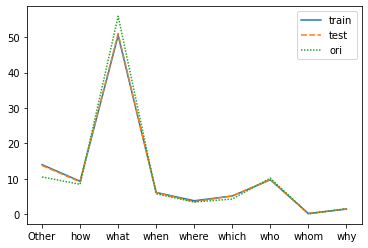

In [47]:
sns.lineplot(data=df)

## Bar plot for model perf

In [22]:
results = pd.read_csv(model_path + 'final-model_eval.csv')
results.drop('Unnamed: 0',axis=1,inplace=True)
results.set_index('Model Name',inplace=True)
results

,F1(Ans),EM(Ans),F1(Plau Ans),EM(Plau Ans)
Model Name,,,,
LSTM Baseline,29.001121,28.225002,0.214623,0.053718
Deep LSTM + GloVe,26.666439,26.030236,0.276301,0.069066
Bi-LSTM + GloVe,28.021961,27.526667,0.281106,0.126621
Bi-LSTM + GloVe + Q2C Attention,33.095119,33.094160,0.000000,0.000000
Bi-LSTM + GloVe + Q2C-C2Q Attention,29.622157,29.130535,0.200039,0.069066
LSTM Baseline + Universal Sentence Encode,24.545255,22.952958,0.618575,0.099762
Bi-LSTM + Universal Sentence Encode,32.025226,31.544010,0.068411,0.023022
Bi-LSTM + Q2C Attention + Universal Sentence Encode,30.695975,30.120482,0.146946,0.042207
BERT + Cased_L-12_H-768_A-12 + DeepPavlov,59.096928,51.362136,22.539289,18.179725


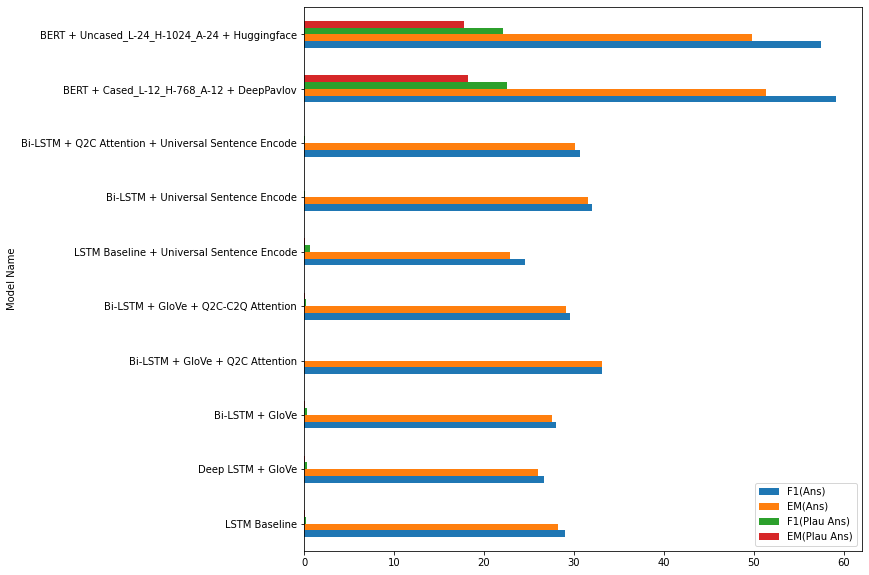

In [17]:
results.plot(kind='barh',figsize=(10,10))

## bAbI data evals

In [ ]:
# we will test babi for 2 models, BERT-huggingface and bilstm-glove-q2c


In [ ]:
# load
loc = [m for m in list_of_models if m['id']=='bilstm-glove-q2c-attention'][0]['loc']
loc
bilstm_glove_q2c_attention = load_mrc_model(loc)
params = loadparams(name='params_withoutstopwords.json')
tokenizer = load_tokenizer(name='glove')

In [2]:
print(bilstm_glove_q2c_attention)
print(berthugmodel)

NameError: ignored

In [144]:
import glob
listofiles = glob.glob(model_path + "bAbI-evals/*.*")

def loadBabi(f):
  babi_1 = pd.read_csv(f,sep='\t',names=['a','b','c','d'])
  # print(babi_1)  
  df = pd.DataFrame(columns=['context','question','answer','plausible_answer','prediction'])
  c = []
  for i in range(len(babi_1)):
    a = babi_1['a'].iloc[i]
    li = a.split(' ')[0]    
    # is NaN check
    if(babi_1['b'].iloc[i] != babi_1['b'].iloc[i]):
      c.append(a.replace(li,'').strip())    

    if(babi_1['b'].iloc[i] == babi_1['b'].iloc[i]):
      # this is answer row
      c_ = "".join(c)
      q = babi_1['a'].iloc[i].replace(li,'').strip()
      ans = babi_1['b'].iloc[i]
      values = ["".join(c),
                babi_1['a'].iloc[i].replace(li,'').strip(),
                babi_1['b'].iloc[i],'']
      zipped = zip(df.columns, values)
      a_dictionary = dict(zipped)
      df = df.append(a_dictionary,ignore_index=True) 
            
    if(li == '15'):
      c = []
  return df 

In [146]:
len(listofiles)

20

In [158]:
dfs = {}
for file in listofiles:
  bt = file.replace(model_path + "bAbI-evals/","")
  print(bt)
  dfs[bt] = loadBabi(file)  

qa3_three-supporting-facts_test.txt
qa2_two-supporting-facts_test.txt
qa1_single-supporting-fact_test.txt
qa19_path-finding_test.txt
qa20_agents-motivations_test.txt
qa18_size-reasoning_test.txt
qa17_positional-reasoning_test.txt
qa16_basic-induction_test.txt
qa15_basic-deduction_test.txt
qa13_compound-coreference_test.txt
qa6_yes-no-questions_test.txt
qa14_time-reasoning_test.txt
qa12_conjunction_test.txt
qa10_indefinite-knowledge_test.txt
qa8_lists-sets_test.txt
qa11_basic-coreference_test.txt
qa9_simple-negation_test.txt
qa7_counting_test.txt
qa5_three-arg-relations_test.txt
qa4_two-arg-relations_test.txt


In [159]:
len(dfs)

20

In [164]:
babi_model_results_bilstm = pd.DataFrame(columns=['bAbI task','F1(Ans)','EM(Ans)','F1(Plau Ans)','EM(Plau Ans)'])
babi_model_results_bert = pd.DataFrame(columns=['bAbI task','F1(Ans)','EM(Ans)','F1(Plau Ans)','EM(Plau Ans)'])

for bt in dfs:
  test = dfs[bt]
  # topkenizer and params is already loaded above 
  print('bAbI Evaluation for ', bt.replace('_test.txt',""))
  test_context_sequence, test_question_sequence = generate_question_context_sequence(context=test["context"].values,
                                question=test["question"].values,
                                question_max_length=params['question_max_length'],
                                padding=params['question_pad_seq'],
                                context_max_length=params['context_max_length']
                                )  
  y_prediction = bilstm_glove_q2c_attention.predict([test_question_sequence,test_context_sequence])
  y_prediction_new,start_pred,end_pred = combine_y(y_prediction,test.shape[0])
  # acc_score,macro_f1_score,micro_f1_score = accuracy_metrics(y_test_new,y_prediction_new)
  y_pred_text = generate_y_preds_text(test,start_pred,end_pred)
  exact_raw, f1_raw, exact_scores_pa,f1_scores_pa = get_raw_scores(test, y_pred_text)
  exact, f1,exact_pa, f1_pa, total = make_eval_dict(exact_raw,f1_raw, exact_scores_pa,f1_scores_pa)
  values = [bt.replace('_test.txt',""),              
            f1,
            exact,
            f1_pa,
            exact_pa]
  zipped = zip(babi_model_results_bilstm.columns, values)
  a_dictionary = dict(zipped)
  babi_model_results_bilstm = babi_model_results_bilstm.append(a_dictionary,ignore_index=True) 
  

bAbI Evaluation for  qa3_three-supporting-facts


100%|██████████| 1000/1000 [00:01<00:00, 956.66it/s]


bAbI Evaluation for  qa2_two-supporting-facts


100%|██████████| 1000/1000 [00:00<00:00, 2395.66it/s]


bAbI Evaluation for  qa1_single-supporting-fact


100%|██████████| 1000/1000 [00:00<00:00, 3259.55it/s]


bAbI Evaluation for  qa19_path-finding


100%|██████████| 1000/1000 [01:04<00:00, 15.50it/s]


bAbI Evaluation for  qa20_agents-motivations


100%|██████████| 1000/1000 [00:00<00:00, 3929.58it/s]


bAbI Evaluation for  qa18_size-reasoning


100%|██████████| 1000/1000 [00:00<00:00, 1254.50it/s]


bAbI Evaluation for  qa17_positional-reasoning


100%|██████████| 1000/1000 [00:04<00:00, 230.26it/s]


bAbI Evaluation for  qa16_basic-induction


100%|██████████| 1000/1000 [00:55<00:00, 18.11it/s]


bAbI Evaluation for  qa15_basic-deduction


100%|██████████| 1000/1000 [00:16<00:00, 61.50it/s]


bAbI Evaluation for  qa13_compound-coreference


100%|██████████| 1000/1000 [00:00<00:00, 2942.16it/s]


bAbI Evaluation for  qa6_yes-no-questions


100%|██████████| 1000/1000 [00:00<00:00, 3446.47it/s]


bAbI Evaluation for  qa14_time-reasoning


100%|██████████| 1000/1000 [00:00<00:00, 2746.33it/s]


bAbI Evaluation for  qa12_conjunction


100%|██████████| 1000/1000 [00:00<00:00, 2796.36it/s]


bAbI Evaluation for  qa10_indefinite-knowledge


100%|██████████| 1000/1000 [00:00<00:00, 3206.66it/s]


bAbI Evaluation for  qa8_lists-sets


100%|██████████| 1000/1000 [00:00<00:00, 2908.72it/s]


bAbI Evaluation for  qa11_basic-coreference


100%|██████████| 1000/1000 [00:00<00:00, 3158.40it/s]


bAbI Evaluation for  qa9_simple-negation


100%|██████████| 1000/1000 [00:00<00:00, 3527.46it/s]


bAbI Evaluation for  qa7_counting


100%|██████████| 1000/1000 [00:00<00:00, 3062.60it/s]


bAbI Evaluation for  qa5_three-arg-relations


100%|██████████| 1000/1000 [00:00<00:00, 2081.31it/s]


bAbI Evaluation for  qa4_two-arg-relations


100%|██████████| 1000/1000 [00:24<00:00, 40.01it/s]


In [165]:
babi_model_results_bilstm

,bAbI task,F1(Ans),EM(Ans),F1(Plau Ans),EM(Plau Ans)
0,qa3_three-supporting-facts,0.0,0.0,0.0,0.0
1,qa2_two-supporting-facts,0.0,0.0,0.0,0.0
2,qa1_single-supporting-fact,0.0,0.0,0.0,0.0
3,qa19_path-finding,0.0,0.0,0.0,0.0
4,qa20_agents-motivations,0.0,0.0,0.0,0.0
5,qa18_size-reasoning,0.0,0.0,0.0,0.0
6,qa17_positional-reasoning,0.0,0.0,0.0,0.0
7,qa16_basic-induction,0.0,0.0,0.0,0.0
8,qa15_basic-deduction,0.0,0.0,0.0,0.0
9,qa13_compound-coreference,0.0,0.0,0.0,0.0


In [ ]:
babi_model_results_bert = pd.DataFrame(columns=['bAbI task','F1(Ans)','EM(Ans)','F1(Plau Ans)','EM(Plau Ans)'])

for bt in dfs:
  test = dfs[bt]
  # topkenizer and params is already loaded above 
  print('bAbI Evaluation for ', bt.replace('_test.txt',""))
  preds = []
  for i in tqdm(range(test.shape[0])):
    try:
      p = ''
      p = predBERTHuggingface(test['question'].iloc[i],test['context'].iloc[i])
    except:
      print('error in prediction')
    preds = preds + [p]
  test['prediction'] = preds
  exact_raw, f1_raw, exact_scores_pa,f1_scores_pa = get_raw_scores(test, test['prediction'].values.tolist())
  exact, f1,exact_pa, f1_pa, total = make_eval_dict(exact_raw,f1_raw, exact_scores_pa,f1_scores_pa)      
  values = [bt.replace('_test.txt',""),              
            f1,
            exact,
            f1_pa,
            exact_pa]
  zipped = zip(babi_model_results_bert.columns, values)
  a_dictionary = dict(zipped)
  babi_model_results_bert = babi_model_results_bert.append(a_dictionary,ignore_index=True) 
  break

In [170]:
test

,context,question,answer,plausible_answer,prediction
0,Daniel left the football there.Daniel took the...,Where was the apple before the bathroom?,office,,
1,Daniel left the football there.Daniel took the...,Where was the apple before the hallway?,office,,
2,Daniel left the football there.Daniel took the...,Where was the apple before the hallway?,office,,
3,Daniel left the football there.Daniel took the...,Where was the football before the garden?,bathroom,,
4,Daniel left the football there.Daniel took the...,Where was the football before the garden?,bathroom,,
...,...,...,...,...,...
995,Daniel went to the bedroom.John grabbed the mi...,Where was the apple before the office?,hallway,,
996,Daniel went to the bedroom.John grabbed the mi...,Where was the apple before the office?,hallway,,
997,Daniel went to the bedroom.John grabbed the mi...,Where was the milk before the kitchen?,bedroom,,
998,Daniel went to the bedroom.John grabbed the mi...,Where was the football before the garden?,bathroom,,
